# Housing Price Regression Model

## 3 Modelling
---

### 3.1 Loading Libraries & Data


In [1]:
# Importing libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, Lasso, LassoCV, 
Ridge, RidgeCV, ElasticNet, ElasticNetCV)
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import scipy
import scipy.cluster.hierarchy as sch
import scipy.stats as ss

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Load dataset
df_combine = pd.read_csv('../project_2/datasets/df_processed.csv', 
                         index_col=[0,1], skipinitialspace=True)

In [3]:
# Split train and test data
df_train = df_combine.loc[('train')].copy()
df_test = df_combine.loc[('test')].copy()

In [4]:
# Get column names
df_combine.columns

Index(['Lot Area', 'Lot Shape', 'Land Slope', 'Overall Qual', 'Overall Cond',
       'Mas Vnr Area', 'Exter Cond', 'Bsmt Cond', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Half Bath', 'Half Bath', 'Kitchen AbvGr',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Paved Drive', 'Pool QC',
       'Misc Val', 'Mo Sold', 'bsmt_fin_sf', 'yr_since_remod', 'porch_area',
       'wood_deck', 'open_porch', 'enclosed_porch', '3ssn_porch',
       'screen_porch', 'large_house', 'SalePrice', 'Bsmt Exposure',
       'Garage Finish', 'Foundation', 'House Style', 'Mas Vnr Type',
       'Bldg Type', 'MS Zoning', 'Alley', 'Land Contour', 'Sale Type',
       'Roof Style', 'Exterior 1st'],
      dtype='object')

We regroup the features for purposes of regression modelling to answer our problem statement.

In [5]:
# Regroup features
baseline = ['Gr Liv Area']

land_features = ['Lot Area', 'Lot Shape', 'Land Slope',
              'MS Zoning', 'Alley', 'Land Contour']
             
house_features = ['Overall Qual', 'Overall Cond', 'House Style', 'Foundation',  'Bldg Type',
                 'Mas Vnr Area', 'Exter Cond', 'Bsmt Cond', 'BsmtFin Type 1', 'BsmtFin Type 2', 
                 'Heating QC', 'Electrical', 'Low Qual Fin SF', 'Bsmt Half Bath', 
                 'Half Bath', 'Kitchen AbvGr', 'Functional', 'Fireplace Qu', 'Garage Qual', 
                 'Paved Drive', 'Pool QC', 'Misc Val', 'Mo Sold', 'bsmt_fin_sf', 
                 'yr_since_remod', 'porch_area', 'porch_area',
                  'wood_deck', 'open_porch', 'enclosed_porch', '3ssn_porch',
                  'screen_porch', 'large_house', 'Bsmt Exposure', 'Garage Finish', 'Mas Vnr Type',
                  'Bldg Type', 'Sale Type', 'Roof Style', 'Exterior 1st']

In [6]:
# Mask for Model 2
baseline_add_land = baseline + land_features

In [7]:
# Mask for Model 3
baseline_add_house = baseline + house_features

In [8]:
# Mask for Model 4
all_features = baseline + land_features + house_features

### Instantiate models
---

In [9]:
def reg_models(X_train, y_train, X_test, y_test, testlabel='test', cv=10):
    '''Instantiate and run 4 types of regression models with cross validation 
    and root mean square error scoring.
    
    Input:
    X_train, y_train, X_test, y_test: Takes in X & y train test split data
    testlabel: String label for test
    cv: Number of cross validation folds
    
    Output:
    ls: LinearRegression Object
    ridge_best: LinearRegression Object
    lasso_best: 
    enet_best:
    df: RMSE scoring table
    '''
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_scores_train = (-cross_val_score(lr, X_train, y_train, cv=cv, 
                                       scoring='neg_root_mean_squared_error')).mean()    
    lr_scores_test = mean_squared_error(y_test, lr.predict(X_test), squared=False)
    
    ridge = RidgeCV(alphas=np.logspace(0, 5, 100), cv=cv)
    ridge.fit(X_train, y_train)    
    ridge_scores_train = (-cross_val_score(ridge, X_train, y_train, cv=cv, 
                                          scoring='neg_root_mean_squared_error')).mean()    
    ridge_best = Ridge(alpha=ridge.alpha_)
    ridge_best.fit(X_train, y_train)
    ridge_scores_test = mean_squared_error(y_test, ridge_best.predict(X_test), squared=False)
    
    lasso = LassoCV(n_alphas=200, cv=5)
    lasso.fit(X_train, y_train)  
    lasso_scores_train = (-cross_val_score(lasso, X_train, y_train, cv=cv, 
                                          scoring='neg_root_mean_squared_error')).mean()
    lasso_best = Lasso(alpha=lasso.alpha_)
    lasso_best.fit(X_train, y_train)
    lasso_scores_test = mean_squared_error(y_test, lasso_best.predict(X_test), squared=False)
    
    enet = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=cv)
    enet.fit(X_train, y_train)
    enet_scores_train = (-cross_val_score(enet, X_train, y_train, cv=cv, 
                                         scoring='neg_root_mean_squared_error')).mean()
    enet_best = ElasticNet(alpha=enet.alpha_, l1_ratio=enet.l1_ratio_)
    enet_best.fit(X_train, y_train)
    enet_scores_test = mean_squared_error(y_test, enet_best.predict(X_test), squared=False)

    data = {'model':['LR', 'Ridge', 'Lasso', 'Enet'],
           'train':[lr_scores_train, ridge_scores_train, lasso_scores_train, enet_scores_train],
            testlabel:[lr_scores_test, ridge_scores_test, lasso_scores_test, enet_scores_test]
           }
    df = pd.DataFrame(data)
    
    print(f'RMSE result table:')
    print(df)
    
    return lr, ridge_best, lasso_best, enet_best, df

### Model 1
Baseline - Predict based on `Gr Liv Area` because its the second highest correlated feature. We choose not to use `Overall Qual` because its a less numerical precision and variation (being an ordinal feature)

#### Scaling, Train Test Split
---

In [10]:
# Select model data
X1 = df_train[['Gr Liv Area']]
y1 = df_train['SalePrice']

ss = StandardScaler()
# use the "fit_transform" function to standardize the X design matrix
X1_scaled = ss.fit_transform(X1)

In [11]:
X1_scaled.shape

(2051, 1)

In [12]:
# Train Test Split
X1_train, X1_holdout, y1_train, y1_holdout = train_test_split(X1_scaled, y1, random_state=42)

#### Model Evaluation

In [13]:
# Run Models
lr1, ridge_best1, lasso_best1, enet_best1, df_result1 = \
    reg_models(X1_train, y1_train, X1_holdout, y1_holdout, 'holdout')

RMSE result table:
   model         train       holdout
0     LR  57369.553440  54942.296701
1  Ridge  57386.381565  55057.195355
2  Lasso  57386.366124  54953.126371
3   Enet  57389.052239  54980.703457


This result would serve as baseline to evaluate the next models.

#### Model 2

Model 2 would be run based on baseline `Gr Liv Area` and `land_features` because it is a common saying that location is the most important when buying a property.

In [14]:
# Get list of categorical features for land_features to dummify
category_columns = [key for key, val in df_combine[land_features].iteritems() 
                    if df_combine[land_features].dtypes[key] == 'object']

In [15]:
# dummify columns
X2_comb = pd.get_dummies(df_combine[baseline_add_land], columns=category_columns, drop_first=True)

In [16]:
# split into train and test
X2_trainholdout = X2_comb.loc[('train')].copy()
X2_test = X2_comb.loc[('test')].copy()

In [17]:
# check shape
X2_trainholdout.shape

(2051, 15)

#### Scaling, Train Test Split
---

In [18]:
# Select model data
X2 = X2_trainholdout
y2 = df_train['SalePrice']

ss = StandardScaler()
# use the "fit_transform" function to standardize the X design matrix
X2_scaled = ss.fit_transform(X2)

In [19]:
# Train test split
X2_train, X2_holdout, y2_train, y2_holdout = train_test_split(X2_scaled, y2, random_state=42)

In [20]:
# Run models
lr2, ridge_best2, lasso_best2, enet_best2, df_result2 = \
    reg_models(X2_train, y2_train, X2_holdout,y2_holdout, 'holdout')

RMSE result table:
   model         train       holdout
0     LR  52174.022339  49161.827468
1  Ridge  52296.839912  49128.939921
2  Lasso  52281.406769  48997.424814
3   Enet  52291.719334  48994.978438


Results are better than the base case, showing that location does have postitive predictive value for `SalePrice`

In [21]:
#getcoefs
coefs2 = pd.DataFrame({'variable':X2.columns,
                            'coef':lasso_best2.coef_,
                            'abs_coef':np.abs(lasso_best2.coef_)})

coefs2.sort_values('coef', inplace=True, ascending=False)
coefs2
#coefs2[coefs2['abs_coef']>0].head(20)

,variable,coef,abs_coef
0,Gr Liv Area,49383.526382,49383.526382
12,Land Contour_HLS,17426.012188,17426.012188
5,MS Zoning_FV,13061.541200,13061.541200
8,MS Zoning_RL,12440.924267,12440.924267
14,Land Contour_Lvl,11649.883276,11649.883276
13,Land Contour_Low,6256.008879,6256.008879
11,Alley_none,6074.948953,6074.948953
1,Lot Area,1341.311529,1341.311529
10,Alley_Pave,814.076090,814.076090
6,MS Zoning_I (all),-0.000000,0.000000


### Model 3

Next, Model 3 would be run based on baseline `Gr Liv Area` and `house_features`, so as be able to compare whether `land_features` or `house_features` is a better predictor of `SalePrice`.

In [22]:
# Get list of categorical features for land_features to dummify
category_columns = [key for key, val in df_combine[house_features].iteritems() 
                    if (df_combine.dtypes[key] == 'object')]

In [23]:
category_columns

['House Style',
 'Foundation',
 'Bldg Type',
 'Bsmt Exposure',
 'Mas Vnr Type',
 'Bldg Type',
 'Sale Type',
 'Roof Style',
 'Exterior 1st']

In [24]:
X3_comb = pd.get_dummies(df_combine[baseline_add_house], columns=category_columns, drop_first=True)

In [25]:
X3_trainholdout = X3_comb.loc[('train')].copy()
X3_test = X3_comb.loc[('test')].copy()

In [26]:
X3_trainholdout.shape

(2051, 98)

#### Scaling, Train Test Split
---

In [27]:
X3 = X3_trainholdout
y3 = df_train['SalePrice']

ss = StandardScaler()
# use the "fit_transform" function to standardize the X design matrix
X3_scaled = ss.fit_transform(X3)

In [28]:
# Train Test Split
X3_train, X3_holdout, y3_train, y3_holdout = train_test_split(X3_scaled, y3, random_state=42)

In [29]:
# Run Models
lr3, ridge_best3, lasso_best3, enet_best3, df_result3 = \
    reg_models(X3_train, y3_train, X3_holdout, y3_holdout, 'holdout')

RMSE result table:
   model         train       holdout
0     LR  2.818682e+13  63956.699916
1  Ridge  2.783830e+04  26596.969098
2  Lasso  2.775612e+04  26031.728423
3   Enet  2.780230e+04  26218.942439


We get way better improvement adding house features compared to adding land features to the baseline model. This shows that, for this dataset at least, house features predict prices better than land features, contrary to conventional wisdom.

In [30]:
#getcoefs
coefs3 = pd.DataFrame({'variable':X3.columns,
                            'coef':lasso_best3.coef_,
                            'abs_coef':np.abs(lasso_best3.coef_)})

coefs3.sort_values('coef', inplace=True, ascending=False)
coefs3[coefs3['abs_coef']==0].head(20)

,variable,coef,abs_coef
57,Mas Vnr Type_CBlock,0.0,0.0
60,Mas Vnr Type_none,0.0,0.0
69,Sale Type_CWD,-0.0,0.0
86,Exterior 1st_CBlock,0.0,0.0
71,Sale Type_ConLD,0.0,0.0
72,Sale Type_ConLI,-0.0,0.0
73,Sale Type_ConLw,0.0,0.0
89,Exterior 1st_ImStucc,0.0,0.0
76,Sale Type_VWD,0.0,0.0
77,Sale Type_WD,0.0,0.0


### Model 4

Can we improve it any further? We combine all selected factors (base, land, house) to do a 4th regression model.

In [31]:
# Get list of categorical features to dummify
category_columns = [key for key, val in df_combine[all_features].iteritems() 
                    if (df_combine.dtypes[key] == 'object')]

In [32]:
# Dummify columns
X4_comb = pd.get_dummies(df_combine[all_features], columns=category_columns, drop_first=True)

In [33]:
# Split to train and test datasets
X4_trainholdout = X4_comb.loc[('train')].copy()
X4_test = X4_comb.loc[('test')].copy()

In [34]:
X4_trainholdout.shape

(2051, 112)

#### Scaling, Train Test Split
---

In [35]:
X4 = X4_trainholdout
y4 = df_train['SalePrice']

ss = StandardScaler()
# use the "fit_transform" function to standardize the X design matrix
X4_scaled = ss.fit_transform(X4)

In [36]:
# Train Test Split
X4_train, y4_train, X4_holdout, y4_holdout = train_test_split(X4_scaled, y4, random_state=42)

In [37]:
# Run Models
lr4, ridge_best4, lasso_best4, enet_best4, df_result4 = \
    reg_models(X4_train, X4_holdout, y4_train, y4_holdout, 'holdout')

RMSE result table:
   model         train       holdout
0     LR  3.078327e+12  6.348693e+13
1  Ridge  2.754997e+04  2.666672e+04
2  Lasso  2.729099e+04  2.636699e+04
3   Enet  2.728595e+04  2.633157e+04


Adding in the location to the combination of base and house features actually increases the error of the model. Hence out of these 4 models, Model 3 is the best and we would use model 3 for Kaggle submission.

### Error analysis

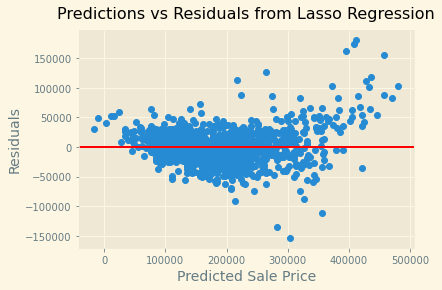

In [38]:
# Plot residual plot for train data residual
plt.style.use('Solarize_Light2')
residuals_train = y3_train - lasso_best3.predict(X3_train)
plt.scatter(lasso_best3.predict(X3_train), residuals_train);
plt.xlabel('Predicted Sale Price', fontdict={'fontsize':14})
plt.ylabel('Residuals', fontdict={'fontsize':14})
plt.title('Predictions vs Residuals from Lasso Regression', fontdict={'fontsize':16}, pad=12)
plt.axhline(y=0, c='red');

The residuals seems evenly spread around zero, but towards the right it seems to be spread out more upwards. Further studies could improve on this by potentially by adding higher coefficient or interaction features.

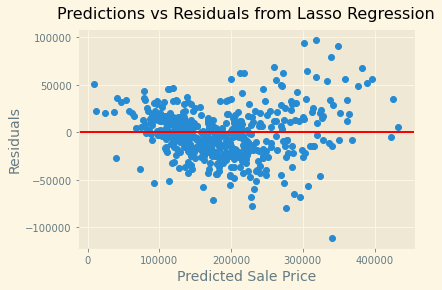

In [39]:
# Plot residual plot for holdout data residual
residuals_holdout = y3_holdout - lasso_best3.predict(X3_holdout)
plt.scatter(lasso_best3.predict(X3_holdout), residuals_holdout);
plt.xlabel('Predicted Sale Price', fontdict={'fontsize':14})
plt.ylabel('Residuals', fontdict={'fontsize':14})
plt.title('Predictions vs Residuals from Lasso Regression', fontdict={'fontsize':16}, pad=12)
plt.axhline(y=0, c='red');

The residuals seems less spread around zero compared to the train data. Perhaps there is still reducible error that can be found, further studies could reduce colinearillty or investigate if the other features which we excluded could explain these variance.

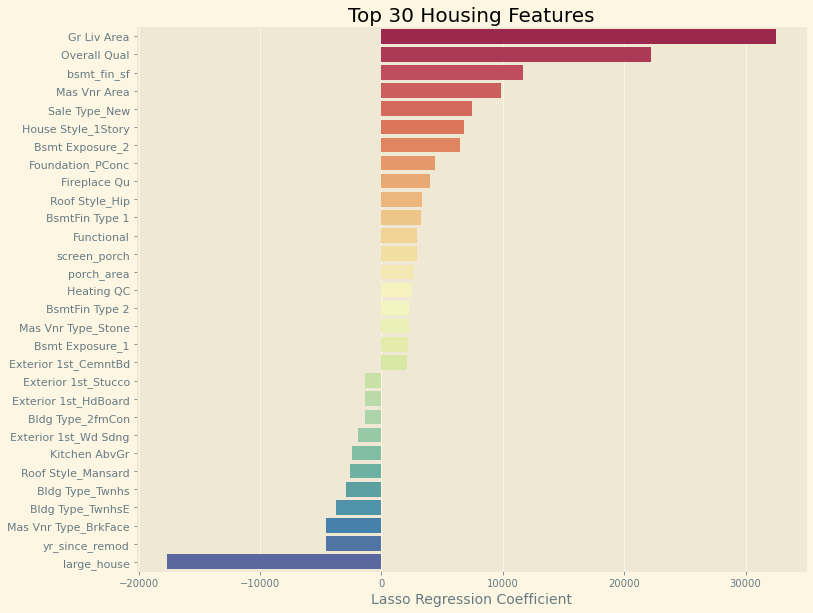

In [132]:
# Create dataframe of features, coefficients and absolute coefficients
lasso_df = pd.DataFrame(columns=['Feature', 'Coef', 'Abs Coef'])
lasso_df['Abs Coef'] = abs(lasso_best3.coef_)
lasso_df['Coef'] = lasso_best3.coef_
lasso_df['Feature'] = X3_comb.columns

# Plot top 30 features (sorted by absolute regression coefficient)
plt.figure(figsize=(12,10))
data = lasso_df.sort_values(by='Abs Coef', ascending=False).head(30)[['Feature', 'Coef']] \
               .sort_values(by='Coef', ascending=False).reset_index(drop=True)
    
ax = sns.barplot(data=data, y='Feature', x='Coef', orient='h', palette='Spectral')
ax.set_ylabel('')
ax.set_yticklabels(data['Feature'], size=11)
ax.set_xlabel('Lasso Regression Coefficient', fontsize=14)
plt.title('Top 30 Housing Features', fontsize=20);

Based on the above, we can see the top 30 housing features that affects home price.

Below, we would calculate the estimated value added to the house if homeowners upgrade their existing features from one type to another. This would be helpful in our AI renovation adviser to suggest possible improvements. 

The largest increase is a $4,600 increase if masonry veneer is upgraded from Cinder Block to Brick Face

However whether this is a cost-effective improvement would depend on the cost to improve the feature.

The Y axis is the existing feature that a house may have, X axis is the targeted improvement feature, and values is improvement to home price in thousands should the improvement be made.



Text(86.09375, 0.5, 'Existing Feature')

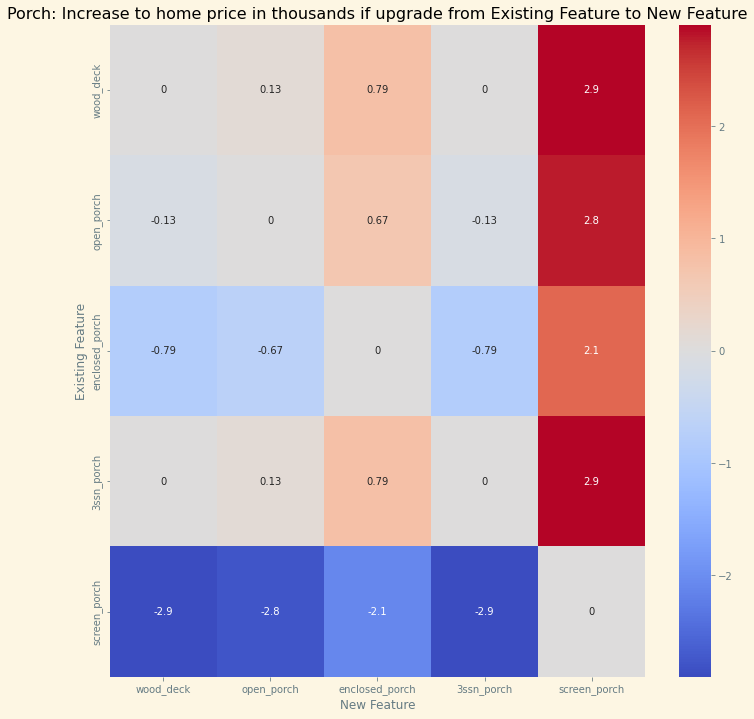

In [135]:
df = lasso_df[lasso_df['Feature'].isin(['wood_deck', 'open_porch', 'enclosed_porch', 
                                    '3ssn_porch','screen_porch'])][['Feature','Abs Coef']]

arr = (df['Abs Coef'].values - df['Abs Coef'].values[:, None])/1000

plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(arr, columns=df['Feature'], index=df['Feature']), center=0, cmap='coolwarm', 
            annot=True)
plt.title('Porch: Increase to home price in thousands if upgrade from Existing Feature to New Feature')
plt.xlabel('New Feature')
plt.ylabel('Existing Feature')

Text(86.09375, 0.5, 'Existing Feature')

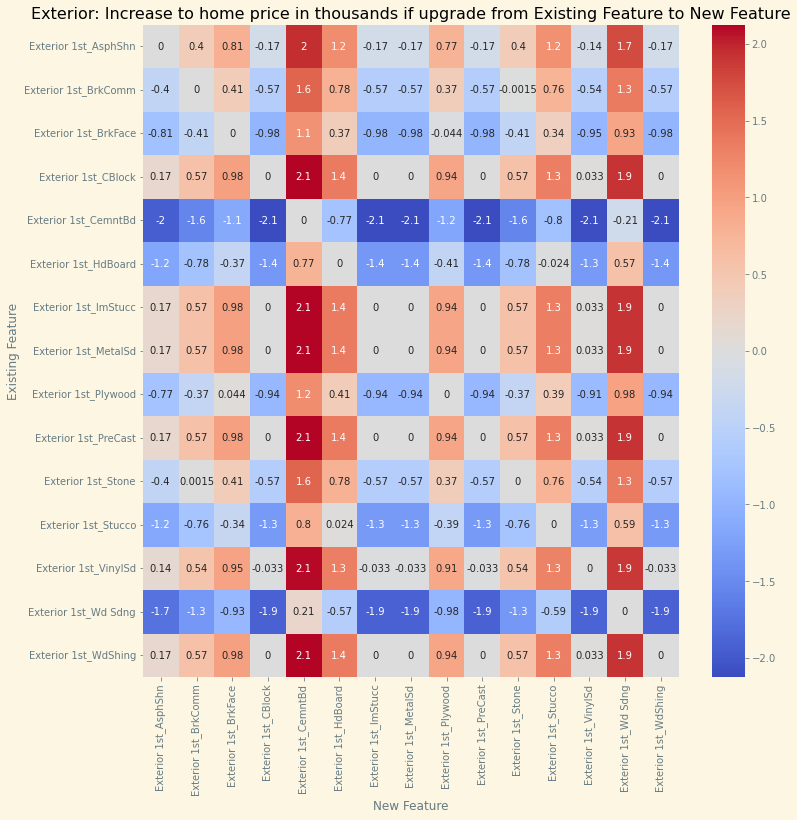

In [134]:
df=lasso_df[lasso_df['Feature'].isin(['Exterior 1st_AsphShn', 'Exterior 1st_BrkComm', 'Exterior 1st_BrkFace',
       'Exterior 1st_CBlock', 'Exterior 1st_CemntBd', 'Exterior 1st_HdBoard',
       'Exterior 1st_ImStucc', 'Exterior 1st_MetalSd', 'Exterior 1st_Plywood',
       'Exterior 1st_PreCast', 'Exterior 1st_Stone', 'Exterior 1st_Stucco',
       'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng', 'Exterior 1st_WdShing'])][['Feature','Abs Coef']]
arr = (df['Abs Coef'].values - df['Abs Coef'].values[:, None])/1000

plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(arr, columns=df['Feature'], index=df['Feature']), center=0, cmap='coolwarm', 
            annot=True)
plt.title('Exterior: Increase to home price in thousands if upgrade from Existing Feature to New Feature')
plt.xlabel('New Feature')
plt.ylabel('Existing Feature')

Text(86.09375, 0.5, 'Existing Feature')

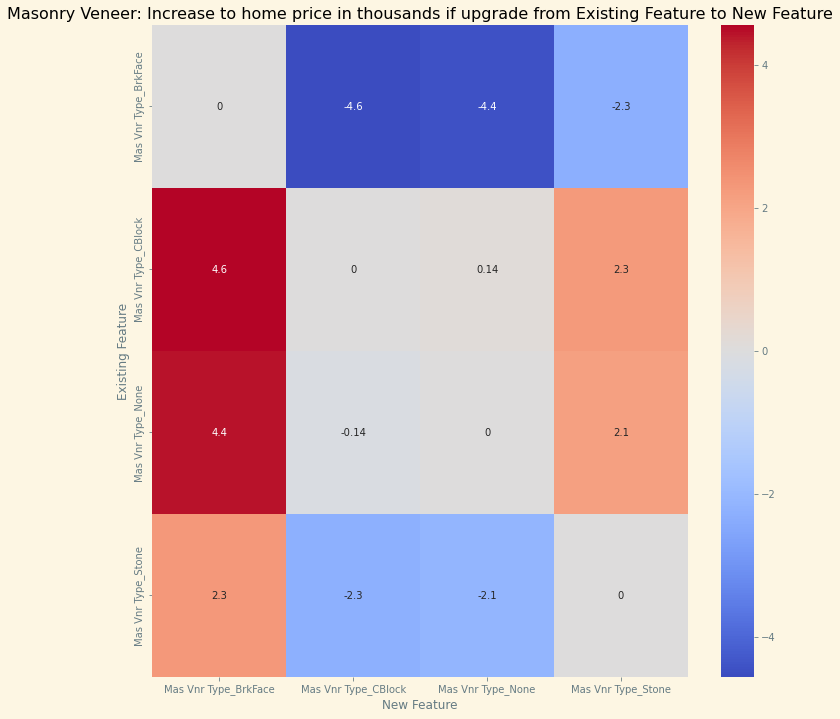

In [140]:
df=lasso_df[lasso_df['Feature'].isin(['Mas Vnr Type_BrkFace',
       'Mas Vnr Type_CBlock', 'Mas Vnr Type_None', 'Mas Vnr Type_Stone',
       ])][['Feature','Abs Coef']]

arr = (df['Abs Coef'].values - df['Abs Coef'].values[:, None])/1000

plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(arr, columns=df['Feature'], index=df['Feature']), center=0, cmap='coolwarm', 
            annot=True)
plt.title('Masonry Veneer: Increase to home price in thousands if upgrade from Existing Feature to New Feature')
plt.xlabel('New Feature')
plt.ylabel('Existing Feature')

Text(86.09375, 0.5, 'Existing Feature')

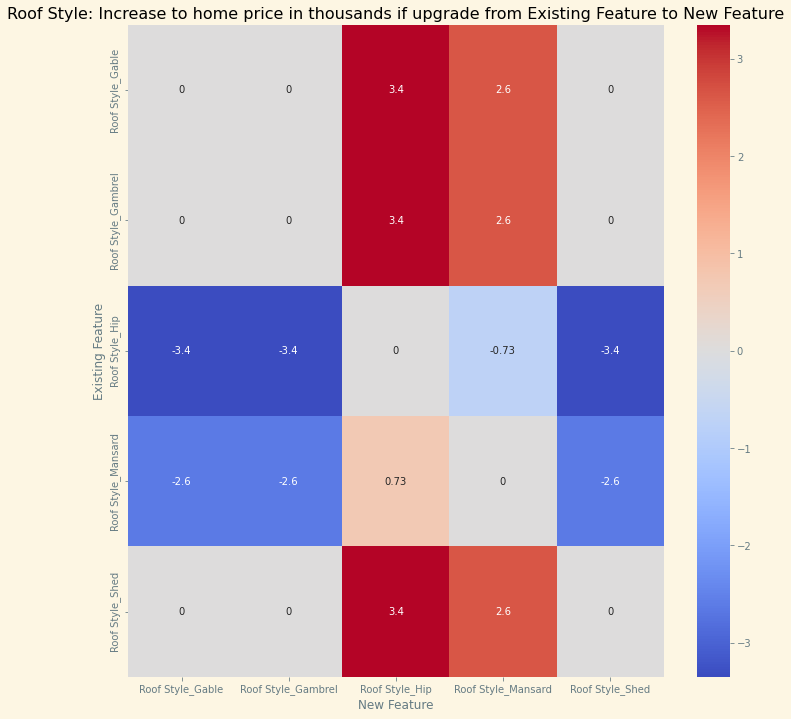

In [141]:
df=lasso_df[lasso_df['Feature'].isin(['Roof Style_Gable', 'Roof Style_Gambrel',
       'Roof Style_Hip', 'Roof Style_Mansard', 'Roof Style_Shed',])][['Feature','Abs Coef']]


arr = (df['Abs Coef'].values - df['Abs Coef'].values[:, None])/1000

plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(arr, columns=df['Feature'], index=df['Feature']), center=0, cmap='coolwarm', 
            annot=True)
plt.title('Roof Style: Increase to home price in thousands if upgrade from Existing Feature to New Feature')
plt.xlabel('New Feature')
plt.ylabel('Existing Feature')

### Kaggle submisson

In [ ]:
# Import raw test data to get the Id column that we removed previously.
df_test = pd.read_csv('../project_2/datasets/test.csv')

In [ ]:
# Refit model on entire training dataset
X3_scaled = ss.fit_transform(X3)
lasso_best3.fit(X3_scaled, y3)

In [ ]:
# Scale test dataset
test_scaled = ss.transform(X3_test)

In [ ]:
final_predictions = lasso_best3.predict(test_scaled)
df_test['SalePrice']=final_predictions

In [ ]:
# Create csv for submission
submission = df_test[['Id','SalePrice']]

In [ ]:
submission.to_csv('./datasets/kaggle_submission_10.csv', index=False)

## Conclusion
---

We have found that based on this dataset, house features impact housing price more than location features, and lasso regression model performed the best.

Coefficients of the regression can be used to inform home owner's renovation plans as to whether they have the potential to be cost-effective. In our model we have the data for estimated improvement to home values should home owners want to upgrade their porch, exterior coverings, masonry veneer and roof.

This would be useful datapoints in our AI renovation adviser to suggest possible improvements. For example, the largest increase we found is a $4,600 increase if masonry veneer is upgraded from Cinder Block to Brick Face. However whether this is a cost-effective improvement would depend on the cost to improve the feature.

Not all categorical features were included, several reasons include because the impact of these features were less significant compared to those selected. Further studies could collect a larger sample size with more balanced sample across categories, and employ principle component analysis to isolate the impact of those variables.

Further studies:

While one conclusion is that house features impact housing price more than location features, it could be that our location features are not refined enough to give significant results. We could investigate how location affects price by measuring distance from key amenities/city center to get a better picture of how location affects price.